<a href="https://colab.research.google.com/github/stonkpab/df-detect/blob/main/df_cnn_temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Initial imports
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, utils
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, Conv2D, MaxPooling2D, Flatten, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from sklearn.utils import shuffle
from keras.applications import Xception
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Face extracted data loaded as pkl file
x_train_raw = joblib.load('/content/drive/My Drive/extracted2/x_train.pkl')
x_test_raw = joblib.load('/content/drive/My Drive/extracted2/x_test.pkl')
y_test_raw = joblib.load('/content/drive/My Drive/extracted2/y_test.pkl')
y_train_raw = joblib.load('/content/drive/My Drive/extracted2/y_train.pkl')

In [ ]:
#Group data by videos of 5 frames each
x_train = np.array([x_train_raw[x:x+5] for x in range(0, len(x_train_raw),5)])
y_train = y_train_raw[::5]
x_test = np.array([x_test_raw[x:x+5] for x in range(0, len(x_test_raw),5)])
y_test = y_test_raw[::5]

In [ ]:
#delete raw data to conserve RAM
del x_train_raw
del x_test_raw
del y_test_raw
del y_train_raw

In [ ]:
#data shapes
print(x_train.shape)
print(len(y_train))
print(x_test.shape)
print(len(y_test))

(1796, 5, 299, 299, 3)
1796
(200, 5, 299, 299, 3)
200


In [ ]:
#vectorize training data
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

In [ ]:
#shuffle data 
x_train_shuffled, y_train_shuffled = shuffle(x_train,y_train)

In [ ]:
#delete unshuffled data to conserve ram
del x_train
del y_train

In [ ]:
#create model
model = Sequential()

#Xception transfer learning with top layers removed and layers frozen
Xception_transfer=Xception(include_top=False,
                 weights='imagenet')
for layer in Xception_transfer.layers:
    layer.trainable = False

#input shape takes 5 frames of pictures with 299 height, width, and 3 color channels
model.add(TimeDistributed(Xception_transfer, input_shape=(5,299,299,3)))
#typical convolutional workflow
model.add(TimeDistributed(Conv2D(64, (3,3), activation="relu")))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=True)) #return sequences set to True b/c followed by another recurrent layer
model.add(LSTM(256, recurrent_dropout=0.2))
#4 dense layers for classification
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation='relu'))
model.add(Dense(64,activation="relu"))
#binary sigmoid does not work with xception, must use Dense layer with softmax activation
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 5, 10, 10, 2048)   20861480  
_________________________________________________________________
time_distributed_9 (TimeDist (None, 5, 8, 8, 64)       1179712   
_________________________________________________________________
time_distributed_10 (TimeDis (None, 5, 4, 4, 64)       0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 5, 1024)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 256)            1311744   
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [ ]:
#categorical cross entropy must be used for softmax activation
model.compile(loss="categorical_crossentropy",
          optimizer="rmsprop",
          metrics=['accuracy'])

In [ ]:
#alarm to signal end of training
from IPython.display import Audio
sound_file = '/content/drive/My Drive/infernogen-ay202/alarm.mp3'

In [ ]:
# CALLBACKS

# ModelCheckpoint callback will save model with the lowest achieved validation loss
fp = '/content/drive/My Drive/extracted2/model.h5'
mc_cb = ModelCheckpoint(filepath = fp, save_best_only = True, verbose = 1)

# early stopping if training for more epochs
es_cb = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3, min_delta = .001, restore_best_weights=True)

# package callback functions into variable
cb_list = [mc_cb, es_cb]

In [ ]:
history = model.fit(x_train_shuffled,
                    y_train_shuffled,
                    validation_split=0.2, #20% of training data used for validation
                    epochs=20,
                    callbacks = cb_list)
Audio(sound_file, autoplay=True) #audio plays once training is complete

Epoch 1/20
45/45 [==============================] - 45s 876ms/step - loss: 0.7172 - accuracy: 0.4930 - val_loss: 0.6924 - val_accuracy: 0.5083

Epoch 00001: val_loss did not improve from 0.46874
Epoch 2/20
45/45 [==============================] - 37s 828ms/step - loss: 0.6961 - accuracy: 0.5263 - val_loss: 0.6832 - val_accuracy: 0.5528

Epoch 00002: val_loss did not improve from 0.46874
Epoch 3/20
45/45 [==============================] - 37s 829ms/step - loss: 0.6818 - accuracy: 0.5957 - val_loss: 0.6819 - val_accuracy: 0.4917

Epoch 00003: val_loss did not improve from 0.46874
Epoch 4/20
45/45 [==============================] - 37s 828ms/step - loss: 0.6560 - accuracy: 0.6126 - val_loss: 0.6678 - val_accuracy: 0.5944

Epoch 00004: val_loss did not improve from 0.46874
Epoch 5/20
45/45 [==============================] - 37s 828ms/step - loss: 0.6240 - accuracy: 0.6855 - val_loss: 0.6772 - val_accuracy: 0.6556

Epoch 00005: val_loss did not improve from 0.46874
Epoch 6/20
45/45 [=======

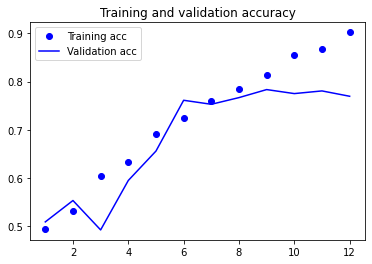

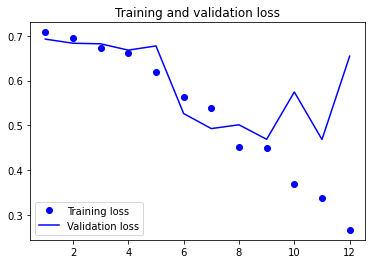

In [ ]:
#plot between training and validation to visualize overfitting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#test accuracy of 78.5%
model.evaluate(x_test,y_test)

7/7 [==============================] - 4s 562ms/step - loss: 0.4972 - accuracy: 0.7850


[0.4971993565559387, 0.7850000262260437]

In [ ]:
#save model to specified file location
model.save("/content/drive/My Drive/extracted2/model.h5")

In [ ]:
#load model from specified file location
model = keras.models.load_model("/content/drive/My Drive/extracted2/model.h5")

In [ ]:
#test predict based off sample shape of numpy arrays filled with 1
model.predict(np.full((1,5,299,299,3),1))

array([[0.8776464, 0.1223536]], dtype=float32)